# Classification Predict Student Solution

© Explore Data Science Academy

---
### Honour Code

I {**YOUR NAME, YOUR SURNAME**}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

### Predict Overview: Twitter Sentiment Classification Challenge

The task involves developing a Machine Learning model to classify tweets based on people's beliefs regarding climate change. The dataset provided contains 43,943 tweets collected between April 27, 2015, and February 21, 2018. Each tweet is labeled with one of four classes: News, Pro, Neutral, or Anti, representing different perspectives on climate change.
Your company has been awarded the contract to:

 1. Analyse the supplied data;
 2. Clean and transform data, including removing noise, handling missing values, and applying text preprocessing techniques like tokenization, stop-word removal, and stemming or lemmatization;
 3. Extract relevant features from the tweet data that can contribute to the classification task;
 4. Choose an appropriate Machine Learning algorithm for the classification task;
 5. Train the model and evaluate using appropriate evaluation metrics such as accuracy, precision, recall, and F1 score;
 6. Deploy to classify new, unseen tweets into the belief classes, and
 7. Explain the inner working of the model to a non-technical audience.

Formally the problem statement was given to you, the senior data scientist, by your manager via email reads as follow:

> In this project you are tasked to model this classification problem, by exploring and preprocessing the data, perform feature engineering, and train a suitable Machine Learning model. The model will learn from the labeled tweets to classify new, unseen tweets into one of the belief classes accurately. The goal is to create a robust and accurate model that can provide valuable insights into people's perceptions of climate change.
 
On top of this, she has provided you with a starter notebook containing vague explanations of what the main outcomes are. 

<a id="cont"></a>

## Table of Contents
<a href=#one>1. Introduction</a>

<a href=#two>2. Problem Statement</a>

<a href=#three>3. Importing Packages</a>

<a href=#four>4. Loading Data</a>

<a href=#five>5. Exploratory Data Analysis (EDA)</a>

<a href=#six>6. Data Engineering</a>

<a href=#seven>7. Modeling</a>

<a href=#eight>8. Model Performance</a>

<a href=#nine>9. Model Explanations</a>

<a href=#ten>10. Conclusion</a>

<a href=#eleven>11. References</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

In today's world, climate change is a pressing global issue that has gained significant attention. Many companies are dedicated to reducing environmental impact and carbon footprints by offering sustainable and environmentally friendly products and services. To gauge public sentiment and understand how their offerings may be received, these companies require insights into people's beliefs regarding climate change.


 <a id="two"></a>
## 2. Problem Statement
<a href=#cont>Back to Table of Contents</a>

Develop a Machine Learning model to classify tweets based on people's beliefs regarding climate change. The dataset includes 43,943 tweets collected between April 27, 2015, and February 21, 2018, labeled with four classes:

- News: The tweet links to factual news about climate change.
- Pro: The tweet supports the belief of man-made climate change.
- Neutral: The tweet neither supports nor refutes the belief of man-made climate change.
- Anti: The tweet does not believe in man-made climate change.

The objective is to create an accurate and robust model that can provide insights into public sentiment on climate change, aiding companies in understanding the reception of their environmentally friendly products and services for informed marketing strategies.

<a id="three"></a>
## 3. Hypothesis
<a href=#cont>Back to Table of Contents</a>

The hypothesis for the classification task of determining whether a person believes in climate change based on their tweet data is as follows:

1. Null Hypothesis (H0): There is no significant relationship between the content of a person's tweet and their belief in climate change.

2. Alternate Hypothesis (HA): The content of a person's tweet is significantly related to their belief in climate change.

Based on this hypothesis, we aim to analyze the tweet data and classify whether a person believes in climate change or not. 

 <a id="four"></a>
## 4. Importing Packages
<a href=#cont>Back to Table of Contents</a>

Importing commonly used packages for data analysis and machine learning tasks in python. Packages contain pre-defined functions, classes, and other resources that can be used to perform specific tasks without having to write the code from scratch.

---
    
| ⚡ Description: Importing Packages ⚡ |
| :--------------------------- |
| In this section you are required to import, and briefly discuss, the libraries that will be used throughout your analysis and modelling. |

---

In [112]:
# Libraries for data loading, data manipulation and data visulisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
# Libraries for data preparation and model building
#import *
import nltk
from nltk import TreebankWordTokenizer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import string
import urllib
# Setting global constants to ensure notebook results are reproducible
#PARAMETER_CONSTANT = ###
# set plot style
sns.set()


#making sure that we can see all rows and cols
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)


<a id="five"></a>
## 5. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

In this section, data is loaded in as a csv file. By loading the data, we can use the libraries to explore data, preprocess, analyze, model and gain insights.

    
| ⚡ Description: Loading the data ⚡ |
| :--------------------------- |
| In this section you are required to load the data from the `df_train` file into a DataFrame. |

---

In [113]:
# load the data
train = pd.read_csv('../resources/data/train.csv')
test = pd.read_csv('../resources/data/test_with_no_labels.csv')
# New fkfkg

<a id="six"></a>
## 6. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



---
    
| ⚡ Description: Exploratory data analysis ⚡ |
| :--------------------------- |
| In this section, you are required to perform an in-depth analysis of all the variables in the DataFrame. |

---


In [114]:
# Check the shape of the train and test datasets
print(train.shape)
print(test.shape)

(15819, 3)
(10546, 2)


In [115]:
# Reading the first 5 rows of the train data
train.head()

,sentiment,message,tweetid
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221
1,1,It's not like we lack evidence of anthropogenic global warming,126103
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954


In [116]:
# Reading the first 5 rows of test data
test.head()

,message,tweetid
0,Europe will now be looking to China to make sure that it is not alone in fighting climate change… https://t.co/O7T8rCgwDq,169760
1,Combine this with the polling of staffers re climate change and womens' rights and you have a fascist state. https://t.co/ifrm7eexpj,35326
2,"The scary, unimpeachable evidence that climate change is already here: https://t.co/yAedqcV9Ki #itstimetochange #climatechange @ZEROCO2_;..",224985
3,@Karoli @morgfair @OsborneInk @dailykos \r\nPutin got to you too Jill ! \r\nTrump doesn't believe in climate change at all \r\nThinks it's s hoax,476263
4,RT @FakeWillMoore: 'Female orgasms cause global warming!'\r\n-Sarcastic Republican,872928


In [117]:
# Checking for the datatypes, null values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


In [118]:
# Checking the sum of null values
train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

### Observations:

- By checking the infomation of the train set, it is confirmed that there are 15819 rows and 3 columns.
- It is also observed that there are no null values present in all the columns.
- Columns sentiment and tweetid contain numerical values, their dtype is int64. The message column contains non-numerical values, therefore it had a dtype object.

In [119]:
def seperate_sent(sent_list):
    sentiments_dict = {}
    for num in sent_list:
        if num in sentiments_dict:
            sentiments_dict[num] += 1
        else:
             sentiments_dict[num] = 1
    return  sentiments_dict  

seperate_sent(train['sentiment'])

{1: 8530, 2: 3640, 0: 2353, -1: 1296}

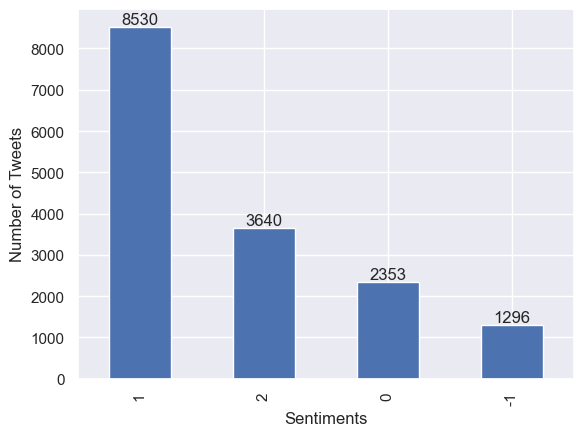

In [120]:
# Counting Number of words
train['sentiment'].value_counts().plot(kind = 'bar')

sentiments = list(seperate_sent(train['sentiment']).keys())
numbers = list(seperate_sent(train['sentiment']).values())

for i, value in enumerate(numbers):
    plt.text(i, value, str(value), ha='center', va='bottom')
plt.xlabel('Sentiments')
plt.ylabel('Number of Tweets')
plt.show()

## Observations:

   - Seperated the Sentiments and counted the number of tweets in each sentiment.
   - From the graph above it is observed that there are 8530 tweets for sentiment 1, 3640 tweets for sentiment 2, 2353 tweets for sentiment 0 and 1296 tweets for sentiment -1.  

In [121]:
nltk.download(['punkt','stopwords'])

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lekal\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lekal\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [122]:
def remove_punctuation(post):
    return ''.join([l for l in post if l not in string.punctuation])

In [123]:
# Create and Check if a new column contains messages with no punxtuations
# Make the test lower case
train['updated message'] = train['message'].apply(remove_punctuation).str.lower()
train['updated message'].iloc[0]


'polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what httpstcoyelvcefxkc via mashable'

In [124]:
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Preprocessing function
def preprocess_text(text):
    """
    Preprocesses the given text by converting it to lowercase, replacing URLs and email addresses with placeholders,
    and removing punctuation.

    Args:
        text (str): The input text.

    Returns:
        str: The preprocessed text.
    """

    # Convert text to lowercase
    text = text.lower()

    # Define the patterns for detecting URLs and email addresses
    pattern_url = r'http\S+'
    pattern_email = r'\S+@\S+'

    # Replace URLs and email addresses with placeholders
    subs_url = 'url-web'
    subs_email = 'email-address'
    text = re.sub(pattern_url, subs_url, text)
    text = re.sub(pattern_email, subs_email, text)

    # Remove web-urls
    text = re.sub(pattern_url, subs_url, text)

    # Return preprocessed text as a string
    return remove_punctuation(text)

# Tokenize message
def tokenize_message(text):
    """
    Tokenizes the given text by splitting it into words, removing stopwords, and removing words with a length less than or equal to 2.

    Args:
        text (str): The input text.

    Returns:
        list: The tokenized words.
    """

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))

    # Remove stopwords and punctuation
    return [word for word in tokens if word not in stop_words and len(word) > 2]


In [125]:
train['updated message'] = train['updated message'].apply(preprocess_text)
train['tokenized message'] = train['updated message'].apply(tokenize_message)

In [126]:
train.head()

,sentiment,message,tweetid,updated message,tokenized message
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221,polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what urlweb via mashable,"[polyscimajor, epa, chief, doesnt, think, carbon, dioxide, main, cause, global, warming, wait, urlweb, via, mashable]"
1,1,It's not like we lack evidence of anthropogenic global warming,126103,its not like we lack evidence of anthropogenic global warming,"[like, lack, evidence, anthropogenic, global, warming]"
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562,rt rawstory researchers say we have three years to act on climate change before it’s too late urlweb urlweb,"[rawstory, researchers, say, three, years, act, climate, change, late, urlweb, urlweb]"
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,todayinmaker wired 2016 was a pivotal year in the war on climate change urlweb,"[todayinmaker, wired, 2016, pivotal, year, war, climate, change, urlweb]"
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954,rt soynoviodetodas its 2016 and a racist sexist climate change denying bigot is leading in the polls electionnight,"[soynoviodetodas, 2016, racist, sexist, climate, change, denying, bigot, leading, polls, electionnight]"


### Observations

- Firstly, we removed the punctuations from all the messages. Made the text to be in lowercase, changed the urls and emails to urlweb and email-address respectively and put all the changes in the new column **updated message**
- Secondly, created a new column that stored the updated message as the tokenized text hence **tokenized message**.

In [127]:
# pro = train.loc[train['sentiment'] == 1, 'updated message']
# anti = train.loc[train['sentiment'] == -1, 'updated message']
# neutral = train.loc[train['sentiment'] == 0, 'updated message']
# news = train.loc[train['sentiment'] == 2, 'updated message']

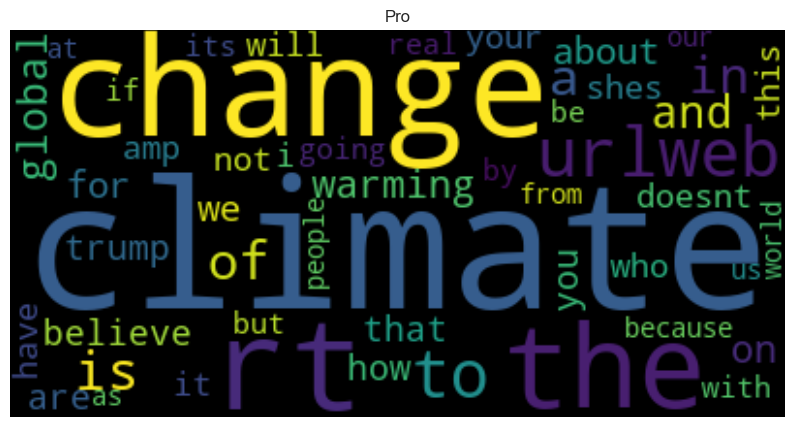

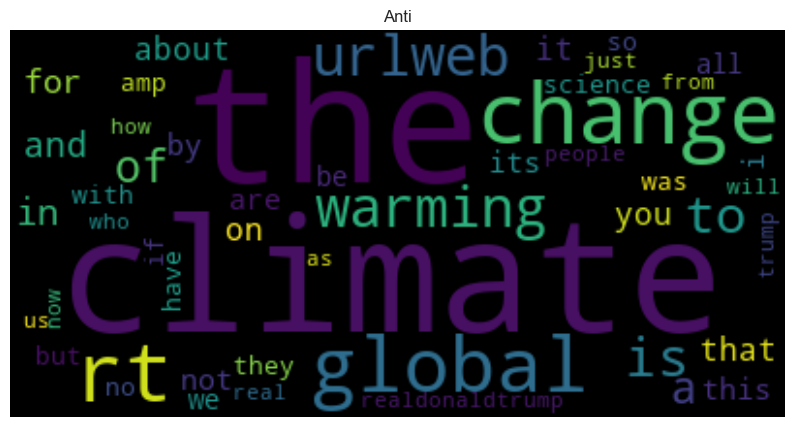

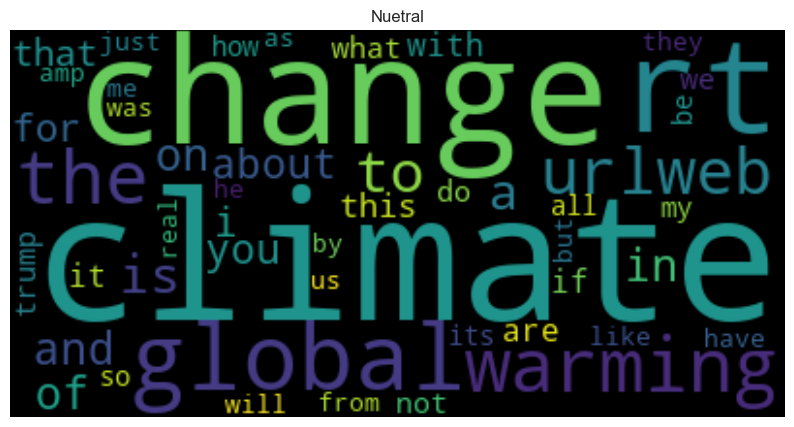

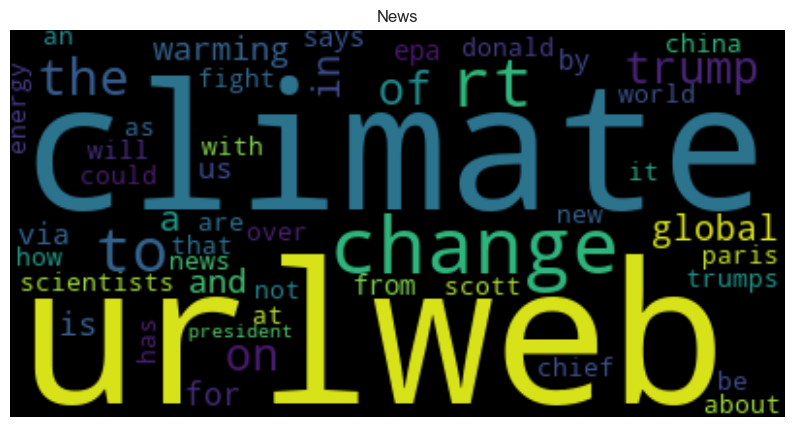

In [128]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Calculate word distribution
text = ' '.join(pro)
words = text.split()
word_counts = Counter(words)

# Generate word cloud
wordcloud = WordCloud(max_words=50)
wordcloud.generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Pro')
plt.show()


# Calculate word distribution
text = ' '.join(anti)
words = text.split()
word_counts = Counter(words)

# Generate word cloud
wordcloud = WordCloud(max_words=50)
wordcloud.generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Anti')
plt.show()


text = ' '.join(neutral)
words = text.split()
word_counts = Counter(words)

# Generate word cloud
wordcloud = WordCloud(max_words=50)
wordcloud.generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuetral')
plt.show()


# Calculate word distribution
text = ' '.join(news)
words = text.split()
word_counts = Counter(words)

# Generate word cloud
wordcloud = WordCloud(max_words=50)
wordcloud.generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('News')
plt.show()

## Observations:

From the cloud words above, it is observed that "climate," "change," "global," "warming," "URL/web," "RT" (retweet) are the mod=st common words used in tweets:

- **Pro**: It indicates that these individuals are likely expressing support for the belief in man-made climate change.
- **Anti**: It indicates that these individuals are likely expressing skepticism or denial of man-made climate change.
- **Neutral**:  It indicates that these individuals are expressing a neutral stance on the belief in man-made climate change.
- **News**: It indicates that these tweets provide factual information and news about climate change, more links were shared related to climate change related issues


<a id="six"></a>
## 6. Data Engineering
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Data engineering ⚡ |
| :--------------------------- |
| In this section you are required to: clean the dataset, and possibly create new features - as identified in the EDA phase. |

---

In [129]:
# View the data after EDA
train.head()

,sentiment,message,tweetid,updated message,tokenized message
0,1,"PolySciMajor EPA chief doesn't think carbon dioxide is main cause of global warming and.. wait, what!? https://t.co/yeLvcEFXkC via @mashable",625221,polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what urlweb via mashable,"[polyscimajor, epa, chief, doesnt, think, carbon, dioxide, main, cause, global, warming, wait, urlweb, via, mashable]"
1,1,It's not like we lack evidence of anthropogenic global warming,126103,its not like we lack evidence of anthropogenic global warming,"[like, lack, evidence, anthropogenic, global, warming]"
2,2,RT @RawStory: Researchers say we have three years to act on climate change before it’s too late https://t.co/WdT0KdUr2f https://t.co/Z0ANPT…,698562,rt rawstory researchers say we have three years to act on climate change before it’s too late urlweb urlweb,"[rawstory, researchers, say, three, years, act, climate, change, late, urlweb, urlweb]"
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year in the war on climate change https://t.co/44wOTxTLcD,573736,todayinmaker wired 2016 was a pivotal year in the war on climate change urlweb,"[todayinmaker, wired, 2016, pivotal, year, war, climate, change, urlweb]"
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, sexist, climate change denying bigot is leading in the polls. #ElectionNight",466954,rt soynoviodetodas its 2016 and a racist sexist climate change denying bigot is leading in the polls electionnight,"[soynoviodetodas, 2016, racist, sexist, climate, change, denying, bigot, leading, polls, electionnight]"


In [130]:
# remove missing values/ features
# Remove the column message
train = train.drop('message', axis = 1)
train.head()

,sentiment,tweetid,updated message,tokenized message
0,1,625221,polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what urlweb via mashable,"[polyscimajor, epa, chief, doesnt, think, carbon, dioxide, main, cause, global, warming, wait, urlweb, via, mashable]"
1,1,126103,its not like we lack evidence of anthropogenic global warming,"[like, lack, evidence, anthropogenic, global, warming]"
2,2,698562,rt rawstory researchers say we have three years to act on climate change before it’s too late urlweb urlweb,"[rawstory, researchers, say, three, years, act, climate, change, late, urlweb, urlweb]"
3,1,573736,todayinmaker wired 2016 was a pivotal year in the war on climate change urlweb,"[todayinmaker, wired, 2016, pivotal, year, war, climate, change, urlweb]"
4,1,466954,rt soynoviodetodas its 2016 and a racist sexist climate change denying bigot is leading in the polls electionnight,"[soynoviodetodas, 2016, racist, sexist, climate, change, denying, bigot, leading, polls, electionnight]"


In [134]:
# create new features

# Lemmatize 
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatize_words(words, lemmatizer):
    """ Groups words of similar meaning together.
    Args:
        words: tokenized words
        lemmatizer: 
    Returns: """
    
    return [lemmatizer.lemmatize(word) for word in words]
train['lemma'] = train['tokenized message'].apply(lemmatize_words, args = (lemmatizer,))
train.head()

,sentiment,tweetid,updated message,tokenized message,lemma
0,1,625221,polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what urlweb via mashable,"[polyscimajor, epa, chief, doesnt, think, carbon, dioxide, main, cause, global, warming, wait, urlweb, via, mashable]","[polyscimajor, epa, chief, doesnt, think, carbon, dioxide, main, cause, global, warming, wait, urlweb, via, mashable]"
1,1,126103,its not like we lack evidence of anthropogenic global warming,"[like, lack, evidence, anthropogenic, global, warming]","[like, lack, evidence, anthropogenic, global, warming]"
2,2,698562,rt rawstory researchers say we have three years to act on climate change before it’s too late urlweb urlweb,"[rawstory, researchers, say, three, years, act, climate, change, late, urlweb, urlweb]","[rawstory, researcher, say, three, year, act, climate, change, late, urlweb, urlweb]"
3,1,573736,todayinmaker wired 2016 was a pivotal year in the war on climate change urlweb,"[todayinmaker, wired, 2016, pivotal, year, war, climate, change, urlweb]","[todayinmaker, wired, 2016, pivotal, year, war, climate, change, urlweb]"
4,1,466954,rt soynoviodetodas its 2016 and a racist sexist climate change denying bigot is leading in the polls electionnight,"[soynoviodetodas, 2016, racist, sexist, climate, change, denying, bigot, leading, polls, electionnight]","[soynoviodetodas, 2016, racist, sexist, climate, change, denying, bigot, leading, poll, electionnight]"


In [141]:
# 
train['token length'] = train['tokenized message'].apply(lambda x: len(x))
train['token characters'] = train['tokenized message'].apply(lambda x: sum(map(lambda s: len(s), x)))
train['lemma length'] = train['lemma'].apply(lambda x: len(x))
train['lemma characters'] = train['lemma'].apply(lambda x: sum(map(lambda s: len(s), x)))
train.head()

,sentiment,tweetid,updated message,tokenized message,lemma,token length,token characters,lemma length,lemma characters
0,1,625221,polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what urlweb via mashable,"[polyscimajor, epa, chief, doesnt, think, carbon, dioxide, main, cause, global, warming, wait, urlweb, via, mashable]","[polyscimajor, epa, chief, doesnt, think, carbon, dioxide, main, cause, global, warming, wait, urlweb, via, mashable]",15,87,15,87
1,1,126103,its not like we lack evidence of anthropogenic global warming,"[like, lack, evidence, anthropogenic, global, warming]","[like, lack, evidence, anthropogenic, global, warming]",6,42,6,42
2,2,698562,rt rawstory researchers say we have three years to act on climate change before it’s too late urlweb urlweb,"[rawstory, researchers, say, three, years, act, climate, change, late, urlweb, urlweb]","[rawstory, researcher, say, three, year, act, climate, change, late, urlweb, urlweb]",11,64,11,62
3,1,573736,todayinmaker wired 2016 was a pivotal year in the war on climate change urlweb,"[todayinmaker, wired, 2016, pivotal, year, war, climate, change, urlweb]","[todayinmaker, wired, 2016, pivotal, year, war, climate, change, urlweb]",9,54,9,54
4,1,466954,rt soynoviodetodas its 2016 and a racist sexist climate change denying bigot is leading in the polls electionnight,"[soynoviodetodas, 2016, racist, sexist, climate, change, denying, bigot, leading, polls, electionnight]","[soynoviodetodas, 2016, racist, sexist, climate, change, denying, bigot, leading, poll, electionnight]",11,81,11,80


In [176]:
# train[['token length','token characters','lemma length']].corr()

<a id="seven"></a>
## 7. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Modelling ⚡ |
| :--------------------------- |
| In this section, you are required to create one or more regression models that are able to accurately predict the thee hour load shortfall. |

---

In [ ]:
# split data

In [ ]:
# create targets and features dataset

In [ ]:
# create one or more ML models

In [ ]:
# evaluate one or more ML models

<a id="eight"></a>
## 8. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model performance ⚡ |
| :--------------------------- |
| In this section you are required to compare the relative performance of the various trained ML models on a holdout dataset and comment on what model is the best and why. |

---

In [ ]:
# Compare model performance

In [ ]:
# Choose best model and motivate why it is the best choice

<a id="nine"></a>
## 9. Model Explanations
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model explanation ⚡ |
| :--------------------------- |
| In this section, you are required to discuss how the best performing model works in a simple way so that both technical and non-technical stakeholders can grasp the intuition behind the model's inner workings. |

---

In [ ]:
# discuss chosen methods logic

<a id="ten"></a>
## 10. Conclusion
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

<a id="eleven"></a>
## 11. References
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>